# 고양이 수염 스티커앱 만들기
## (Camera_Sticker)  
  
***
### Step1. 이미지 준비하기

In [259]:
# 라이브러리 import
import cv2 # 이미지 처리를 위한 라이브러리
import matplotlib.pyplot as plt # 이미지 출력을 위한 라이브러리
import numpy as np 
print("라이브러리 import완료!")

라이브러리 import완료!


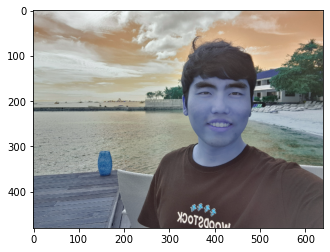

In [260]:
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

plt.imshow(img_bgr)
plt.show()

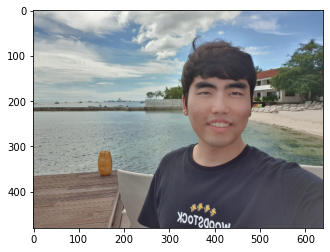

In [261]:
# opencv는 이미지채널을 RGB가 아닌 BGR을 사용하기때문에 푸르게 보임.
# 따라서 cv2.cvtcolor(이미지경로, cv2.COLOR_BGR2RGB)를 사용하여야함.
# BGR채널을 RGB로 변경.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### Step2. 얼굴 검출 & 랜드마크 검출하기

In [262]:
# 얼굴 검출을 위한 라이브러리 import
import dlib
detector_hog = dlib.get_frontal_face_detector() # 얼굴 검출기 선언
print("검출기 선언 완료!")

검출기 선언 완료!


In [263]:
# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1) # 찾은 얼굴영역의 좌표
print(dlib_rects)
print("bounding box 추출 완료!")

rectangles[[(339, 133) (494, 288)]]
bounding box 추출 완료!


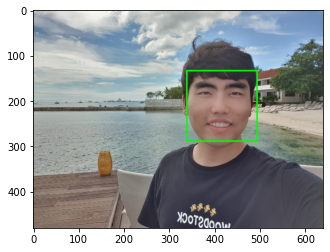

In [264]:
# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [265]:
# landmark 모델 불러오기
import os
# 모델의 위치주소
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("랜드마크 모델 불러오기 완료!")

랜드마크 모델 불러오기 완료!


In [266]:
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))


68


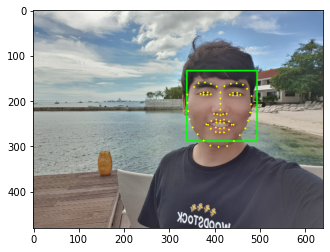

In [267]:
# 랜드마크 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용 위치 확인하기

In [268]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = (landmark[33][0]+landmark[30][0])//2
    y = (landmark[33][1]+landmark[30][1])//2
    w = dlib_rect.width() # 스티커의 넓이
    h = dlib_rect.width() # 스티커의 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(413, 219)
(x,y) : (413,225)
(w,h) : (156,156)


In [269]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 형상 확인
# img_sticker_re = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
# plt.imshow(img_sticker_re)
# plt.show()

(156, 156, 3)


In [270]:
refined_x = x - img_sticker.shape[1]//2     # left
refined_y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (335,147)


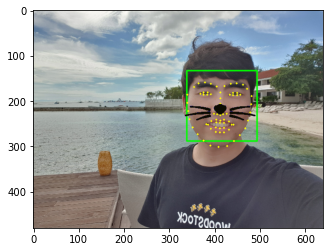

In [271]:
# 스티커 적용위치 확인
if (refined_x or refined_y) > 0:# 스티커가 사진바깥을 벗어나지 않을때
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
else : # 스티커가 x혹은 y방향으로 사진바깥으로 벗어날 때
    if refined_x < 0:
        img_sticker = img_sticker[-refined_x:] # 범위를 벗어난 이미지를 잘라냄
        refined_x = 0 # x 좌표를 수정해줌
        sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.show()
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:] # 범위를 벗어난 이미지를 잘라냄
        refined_y = 0 # x 좌표를 수정해줌
        sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.show()

### Step 4. 스티커 적용하기

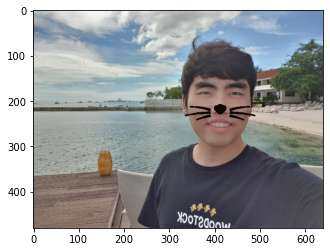

In [272]:
if (refined_x and refined_y) > 0:# 스티커가 사진바깥을 벗어나지 않을때
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    
else : # 스티커가 x혹은 y방향으로 사진바깥으로 벗어날 때
    if refined_x < 0:
        img_sticker = img_sticker[-refined_x:] # 범위를 벗어난 이미지를 잘라냄
        refined_x = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:] # 범위를 벗어난 이미지를 잘라냄
        refined_y = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()

### Step 5. 변수에 따른 스티커적용
***
- 기본사진적용(레이첼 맥아담스)

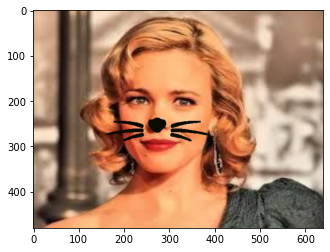

In [273]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel0.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# plt.imshow(img_show_rgb)
# plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = (landmark[33][0]+landmark[30][0])//2
    y = (landmark[33][0]+landmark[30][1])//2
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))   
    
x = x - img_sticker.shape[1]//2     # left
y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


- 정면 얼굴의 경우 랜드마크를 잘 인식하여 스티커를 원하는 위치에 잘 붙였다.
***
- 얼굴의 각도 변형(레이첼 맥아담스)

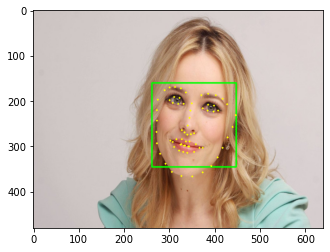

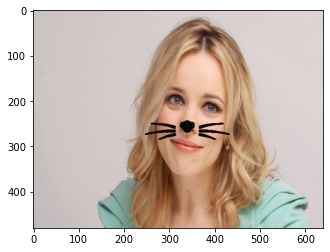

In [274]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel1.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = (landmark[33][0]+landmark[30][0])//2
    y = (landmark[33][1]+landmark[30][1])//2
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))   
    
x = x - img_sticker.shape[1]//2     # left
y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


- 얼굴의 각도가 변형된 경우에는 스티커의 위치는 맞았으나, 각도의 변형이 필요하였다.
***
- 얼굴의 각도 변형_옆얼굴(레이첼 맥아담스)

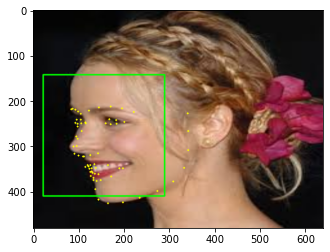

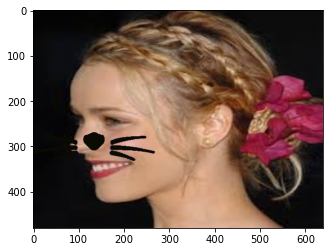

In [280]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel2.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))   
  
refined_x = x - (img_sticker.shape[1]//2)     # left
refined_y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
# 스티커 적용위치 확인
if refined_x > 0 and refined_y > 0:# 스티커가 사진바깥을 벗어나지 않을때
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    
else : # 스티커가 x혹은 y방향으로 사진바깥으로 벗어날 때
    if refined_x < 0:
        img_sticker = img_sticker[-refined_x:] # 범위를 벗어난 이미지를 잘라냄
        refined_x = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:] # 범위를 벗어난 이미지를 잘라냄
        refined_y = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()


- 옆얼굴의 경우에는 랜드마크의 위치가 달라지면서 얼굴은 인식하였으나, 스티커의 정확한 위치를 찾기 힘들었다.
***
- 얼굴의 조명 변형(레이첼 맥아담스)

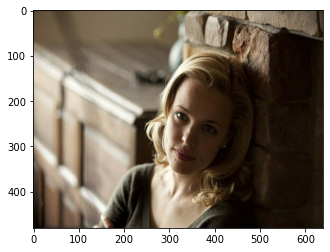

(269, 269, 3)
(x,y) : (-22,188)
(x,y) : (0,188)


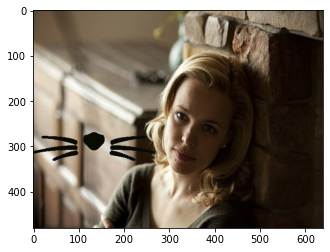

In [276]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel5.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = (landmark[33][0]+landmark[30][0])//2
    y = (landmark[33][1]+landmark[30][1])//2
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))   

refined_x = x - (img_sticker.shape[1]//2)     # left
refined_y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    
# 스티커 적용위치 확인
if refined_x > 0 and refined_y > 0:# 스티커가 사진바깥을 벗어나지 않을때
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    
else : # 스티커가 x혹은 y방향으로 사진바깥으로 벗어날 때
    if refined_x < 0:
        img_sticker = img_sticker[-refined_x:] # 범위를 벗어난 이미지를 잘라냄
        refined_x = 0 # x 좌표를 수정해줌
        print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:] # 범위를 벗어난 이미지를 잘라냄
        refined_y = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refㅠined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()

- 얼굴의 조명이 어둡게 변경된 경우에는 얼굴인식을 어려워하는 모습을 보였다. 얼굴인식 박스자체가 없어 이전에 했던 결과를 다시 가져온 것을 볼수 있다.
***
- 촬영거리의 조정(레이첼 맥아담스)

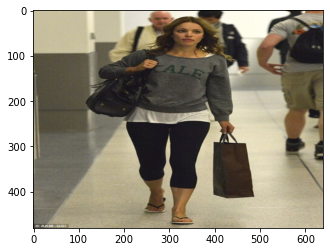

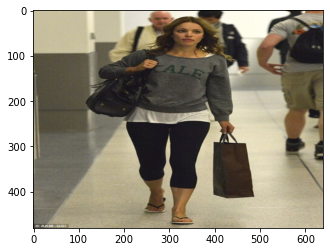

In [283]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel3.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = img_sticker.shape[1]
    h = img_sticker.shape[0]    

refined_x = x - (img_sticker.shape[1]//2)     # left
refined_y = y - img_sticker.shape[0]//2     # top

    
# 스티커 적용위치 확인
# np.where(조건, 참일경우, 아닐경우)
if refined_x > 0 and refined_y > 0:# 스티커가 사진바깥을 벗어나지 않을때
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    
else : # 스티커가 x혹은 y방향으로 사진바깥으로 벗어날 때
    if refined_x < 0:
        img_sticker = img_sticker[-refined_x:] # 범위를 벗어난 이미지를 잘라냄
        refined_x = 0 # x 좌표를 수정해줌       
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:] # 범위를 벗어난 이미지를 잘라냄
        refined_y = 0 # x 좌표를 수정해줌
        sticker_area = img_bgr[refㅠined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.show()


- 촬영거리를 멀게 해서 찍었을때에도 앞의 조명이 변경되었을때와 같이 얼굴을 인식하지 못하는 것을 확인할 수 있었다.
***
### **결론**
> **이번에 만들어 본 카메라 스티커 앱은 기본적으로 얼굴에 랜드마크를 적용하여 해당 랜드 마크의 위치로 스티커를 이동시키는 방법으로 제작되었다.  
> 그렇기 때문에 얼굴인식을 하지못하여 랜드마크를 형성할 수 없으면 스티커또한 붙일 수 없었다.  
> 어떠한 조건들이 얼굴인식을 저해하고, 스티커의 위치를 이상하게 만드는지 레이첼 맥아담스의 사진들을 가지고 확인해 보았다.**  
> **확인결과,** ***`정면 혹은 얼굴의 각도 변형과 같이 얼굴이 전부 보이는 경우`***__에는 스티커를 붙이는 과정들이 잘 작동 되었다.  
> 그러나 스티커는 정면을 기준으로 생각하고 만들었기 때문에 각도가 변형됨에 따라 스티커를 부착하였을 경우에 괴리감이 느껴졌다.  
> 또한, 얼굴을 옆으로 하고 찍었을 때에는 얼굴을 인식하지만 랜드마크의 위치가 겹치거나,  
> 이상하게 인식되어 스티커의 위치또한 정면의 위치와 다소 달랐다.__  
> ***`조명변화 및 사진촬영거리`***__에 따라서도 얼굴의 인식정도가 달라졌는데, 조명이 어두울수록 얼굴인식이 되는 정도가 적었고,  
> 촬영거리가 멀어 얼굴이 매우 작게 나오는 경우에도 마찬가지로 얼굴을 인식하지못해서 랜드마크를 형성하지못해 스티커를 부착하지 못했다.  
> 즉, 얼굴에 스티커를 붙이는 기능은 1)최대한 밝은 조명에서 2)얼굴을 정면으로 하고 3)적당한 거리에서 촬영한 사진을 활용하는 것이  
> 최적이라고 판단된다.__
***
### **회고**
> **이번에 만든 카메라 스티커 앱은 생각보다 어려웠던 것 같다.  
> 프로젝트 이전에 연습으로 진행했던 부분이랑 실제로 적용하는 부분에서 사용하는 코드가 미묘하게 달랐던 탓이었다.  
> 때문에 스티커를 코로 유도하는 부분을 고려하지 못했고, 스티커는 계속 이마에 붙어있었다.  
> 차후에 코드를 찬찬히 살펴보면서 해당부분을 고려하여 수정한 뒤에야 제대로 작동했다.  
> 덕분에 2시간정도는 코드를 뜯어보면서 코드를 잘 살펴볼 수 있게 된 것 같다.  
> 계속해서 진행되는 노드들도 이렇게 코드를 뜯어야 진행할 수 있는 노드라면 시간이 꽤 많이 필요할 것 같다.**